# Studying artists' career to understand the patterns and their determinants

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import unicodedata
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
# %matplotlib inline

In [2]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
global color_h, color_f, color_b, PLOTDIM, FREQYEARS
color_h = "gold"
color_f = "royalblue"
color_b = "lightgray"
PLOTDIM = (9,6)
FREQYEARS = 10
my_cm = LinearSegmentedColormap.from_list("colormap", [color_h, color_f], N=100)

In [3]:
matplotlib.font_manager._rebuild()
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['font.sans-serif'] = 'Roboto'
plt.rcParams['font.weight'] = 500
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [4]:
def linearize(str1):
    d = [str1[0]] + [str1[i] for i in range(1,len(str1)) if str1[i-1] != str1[i]]
    return ''.join(d)

#### Import data

In [5]:
raw_authors = pd.read_csv('../data/ALL_AUTHORS (live_work + clean nat).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art = pd.read_csv('../data/ALL_ARTWORKS (for stats use ONLY).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art['groupcol'] = raw_art['related'].fillna(value='') + raw_art['acquisition'].fillna(value='')

In [6]:
# On travaille en points de contact
art = raw_art.groupby(['authors', 'collection', 'acquisition_year']).first().reset_index()
art = art[art['acquisition_year'] > 1945]
raw_authors['live_and_work'] = raw_authors['live_and_work'].replace({'0': None})
print(art.shape, raw_authors.shape)

(71660, 117) (35958, 23)


In [7]:
# raw_authors.columns

In [8]:
museums = pd.read_csv('../data/MUSEUMS_AND_VISITORS.csv', encoding='utf-8', sep=',', low_memory=False)

In [9]:
art[art.collection.str.contains("Fonds municipal d'art contemporain")]

,authors,collection,acquisition_year,_id,ensemble_id,nb_elements,related,type,recap_inventory,recap_title,recap_nature,title_notice,title_list,title_ensemble,collection_department,dimensions_additional,inscriptions,expositions_without_current,expositions,bibliography,copyright,author_in_common,is_dissoc,acquisition_mode,recap_copyright,date_creation,domain,domain_leaf,domain_deno_for_grid,domain_description_mst,comments,recap_description,recap_authors,authors_notice,authors_list,dimensions,recap_dimensions,acquisition,inventory,inventory_for_grid,key_words_thema,rights_management_leaf,default_tooltip_ua_description,authors_name_complement,authors_site,authors_documents,authors_video,authors_nationality,authors_birth_death,live_and_work,author_bibliography,recap_nationality,recap_name_complement,recap_birth_death,recap_live_and_work,recap_author_bibliography,recap_live_work,nb_images,medias,recap_image_unavailable,localisation_if_deposit,number_provisory,key_words_icono,image_unavailable,title_serial,key_words_movement,title_attributed,creation_stage,domain_deno,deposit_number,deposit_number_for_grid,tirage_design,number_exhibition,realisation_location,recap_multi,dimensions_without_margin,tirage,collaborators_design,authors_live_work,collaborators,tirage_photo,title_old,number_entry,production_circumstances,subtitle,number_identification,number_artist_studio,title_other,text_notes,title_old_by_artist,number_document,title_collection,number_depositary_or_loaner,recap_bibliography,ensemble,old_owners,recap_title_trad,number_artist,trans_title_attributed,number_isbn,number_succession,trans_subtitle,number_issn,mnam_mnr,trans_title_serial,number_catalogue,number_frame,trans_title_ensemble,trans_title_other,trans_title_old,old_attributions,acquisition_mode_clean,Gender,age_at_acquisition,nationality,is_first,groupcol
14,110000000000192,Fonds municipal d'art contemporain de la Ville...,2014.0,2.000000e+14,NaN,NaN,NaN,individual,NaN,NaN,NaN,AVL Ville,AVL Ville,NaN,Arts Plastiques,NaN,S.N.R. : [Signature sur une étiquette] / AVL 0...,NaN,NaN,NaN,© Atelier Van Lieshout,a,NaN,Achat,NaN,2000,Estampe,Estampe,Estampe,Impression laser rehaussée à l'aquarelle et a...,NaN,NaN,NaN,ATELIER VAN LIESHOUT,ATELIER VAN LIESHOUT,NaN,NaN,Achat à Jousse Entreprise en 2014,CM2014.2.1,CM2014.2.1,NaN,..Droits directs par l'artiste,Impression laser rehaussée à l'aquarelle et a...,NaN,<a href='http://www.ateliervanlieshout.com' re...,NaN,NaN,NaN,NaN,Vit et travaille à Rotterdam (Pays-Bas),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,90000000491686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ed. 1/5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Achat,non renseigné,NaN,NaN,0.0,Achat à Jousse Entreprise en 2014
58,110000000000223,Fonds municipal d'art contemporain de la Ville...,1953.0,2.000000e+14,NaN,NaN,NaN,individual,NaN,NaN,NaN,Fleurs dans un vase,Fleurs dans un vase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domaine public,a,NaN,Don,NaN,s.d.,Peinture,Peinture,Peinture,Huile sur toile,NaN,NaN,NaN,Emile Jean-Baptiste Philippe BIN,BIN Emile Jean-Baptiste Philippe,46 x 38 cm,NaN,Don en 1953,CMP9568,CMP9568,NaN,..Domaine public,Huile sur toile,NaN,NaN,NaN,NaN,française,"Paris (France), 1825 - Paris (France), 1897",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no_image,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Don,masculin,128.0,française,0.0,Don en 1953
59,110000000000223,Fonds municipal d'art contemporain de la Ville...,1988.0,2.000000e+14,NaN,NaN,NaN,individual,NaN,NaN,NaN,Portrait de Rollin,Portrait de Rollin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Domaine public,a,NaN,Achat,NaN,s.d.,Peinture,Peinture,Peinture,Huile sur toile,NaN,NaN,NaN,Emile Jean-Baptiste Philippe BIN,BIN Emile Jean-Baptiste Philippe,120 x 83 cm,NaN,Achat en 198

#### Encode collections into broader categories

In [10]:
art = art[pd.notnull(art['collection'])]
art['collection_category'] = None
for i, row in art.iterrows():
    museum = row['collection']
    if "frac" in museum.lower():
        cat = 'F'
    elif "musée national d'art moderne" in museum.lower():
        cat = 'P'
    elif "centre national des arts plastiques" in museum.lower():
        cat = 'C'
    elif "musée" in museum.lower():
        cat = 'M'
    else:
        cat = 'A'
    art.at[i, 'collection_category'] = cat

In [11]:
art['collection_category'].value_counts()

C    21387
M    17243
A    11324
P    10983
F    10723
Name: collection_category, dtype: int64

In [12]:
def compute_acquisition_year(row):
    ind = row['Id artist']
    a = art[art['authors'].str.contains(str(ind))].sort_values('acquisition_year')
    return '|'.join([str(int(x)) for x in a['acquisition_year'].values])

In [13]:
def compute_sequence(row):
    ind = str(row['Id artist'])
    a = art[art['authors'].str.contains(str(ind))].sort_values('acquisition_year')
    print(ind)
    return ''.join([x for x in a['collection_category'].values])

In [14]:
def compute_art_count(row):
    dates = row['acquisition_year']
    if not pd.isnull(dates):
        dates = [int(d) for d in re.split('\|', dates)]
        return len(dates)

In [15]:
def compute_first_acquisition(row):
    dates = row['acquisition_year']
    if not pd.isnull(dates):
        dates = [int(d) for d in re.split('\|', dates)]
        return min(dates)

In [16]:
def compute_last_aquisition_alive(row):
    dates = row['acquisition_year']
    if not pd.isnull(dates):
        dates = [int(d) for d in re.split('\|', dates)]
        if not pd.isnull(row['Death year']):
            dates = [d for d in dates if d <= row['Death year']]
        if len(dates) > 0:
            raw_authors.at[i, 'last_aquisition_alive'] = max(dates)

In [17]:
raw_authors['acquisition_year'] = raw_authors.apply(compute_acquisition_year, axis=1).replace({'': None})

In [18]:
raw_authors['sequence'] = raw_authors.apply(compute_sequence, axis=1)

380000000034856
6664664
6663648
6660426
6660563
6660321
6660552
9000000000087517
580000000000223
9000000000087765
9000000000087636
9000000000083671
200000000003453
6663556
9000000000080871
150000000000763
9000000000084295
9000000000087680
9000000000086016
9000000000087707
9000000000075722
230000000097737
9000000000072746
9000000000076034
9000000000083684
9000000000065376
140000000002175
9000000000087627
580000000000066
140000000007398
9000000000065377
140000001166653
140000001212952
140000001212951
9000000000080013
570000000000007
9000000000078288
140000001212953
150000000000922
180000000000076
140000001212954
9000000000075938
9000000000082461
9000000000068399
420000000002343
140000000009523
140000000009822
9000000000083948
9000000000068400
9000000000068401
9000000000078410
240000000000326
9000000000067802
9000000000065378
9000000000068382
9000000000081480
9000000000084841
420000000000030
250000000000757
9000000000072745
200000000002507
140000000003403
140000000004221
140000000003394
9

140000000008227
9000000000080525
9000000000076376
580000000000212
200000000001098
9000000000076377
140000000003186
140000000003380
140000000004477
200000000001399
200000000001400
140000000004209
9000000000073897
140000000009689
9000000000071327
9000000000067595
140000000005814
9000000000065805
9000000000076089
200000000001401
230000000086728
9000000000080942
9000000000084787
200000000001402
9000000000072442
140000000007666
9000000000079147
9000000000082214
200000000003014
9000000000073308
200000000001241
9000000000075569
430000000032264
140000000004861
9000000000073898
9000000000073899
9000000000080189
9000000000073900
200000000002514
9000000000067908
9000000000068946
140000000005308
140000000007667
9000000000077567
9000000000083818
200000000276822
9000000000068947
200000000001403
140000001013217
200000000001242
9000000000068948
200000000002453
9000000000085311
140000000008229
140000000005151
250000000000535
9000000000068372
200000000003145
9000000000073902
140000000004988
900000000007

200000000001166
140000000004024
200000000002725
140000000004856
9000000000076811
190000000000046
9000000000068980
200000000107474
200000000001252
9000000000073921
580000000000216
9000000000073922
9000000000072448
9000000000083933
250000000097471
140000001648288
9000000000071487
50000000000072
9000000000077571
9000000000078464
140000000009879
9000000000082681
9000000000078465
9000000000081604
230000000026686
9000000000082405
200000000066531
140000000002580
250000000000213
9000000000065834
9000000000085840
140000000005879
140000000004941
580000000016131
9000000000065835
9000000000083791
310000000000140
9000000000076678
9000000000068983
9000000000065836
9000000000079951
9000000000072065
9000000000076812
9000000000078329
9000000000087757
140000000007687
140000000009542
250000000109271
140000000008259
9000000000068309
200000000002919
430000000014693
140000000003133
140000000005741
580000000000217
9000000000076679
9000000000073923
200000000001411
9000000000079580
200000000003246
900000000007

9000000000072623
9000000000087558
9000000000089569
9000000000073181
9000000000076686
9000000000082439
9000000000085610
9000000000082738
9000000000087639
9000000000067538
9000000000078687
230000000026715
6660630
9000000000073405
9000000000078035
9000000000079674
9000000000079675
9000000000082689
140000000007040
140000000008285
200000000003454
9000000000072066
9000000000072076
140000000010077
9000000000083506
9000000000069008
190000000064872
9000000000078688
9000000000084364
60000000000540
150000000000920
580000000000227
9000000000080643
380000000034474
580000000000100
9000000000082532
140000000009622
150000000000739
9000000000073940
9000000000065855
200000000001423
200000000002589
140000000006130
140000000007699
140000000004083
9000000000082739
9000000000069258
9000000000071213
140000001004694
140000000003573
140000000008286
9000000000069009
9000000000065856
9000000000065857
9000000000075837
9000000000070558
9000000000069010
9000000000069011
9000000000076914
390000000000028
900000000007

9000000000080975
9000000000085489
570000000000027
140000000008305
9000000000071930
9000000000077574
9000000000077575
9000000000067843
140000000005002
9000000000084171
140000000008306
9000000000072069
9000000000082459
300000000006102
110000000107574
400000000010555
9000000000068324
9000000000084447
9000000000073970
150000000000734
9000000000073971
140000000002196
450000000043173
9000000000078702
140000000006768
9000000000075751
9000000000083026
140000000006229
490000000013488
9000000000085183
9000000000085184
9000000000065876
110000000107575
580000000000235
9000000000073972
9000000000071931
9000000000080191
9000000000068274
9000000000067039
310000000034269
200000000001434
9000000000085864
140000000008307
200000000003219
9000000000082920
9000000000078703
140000000004424
140000000008309
200000000001269
9000000000080852
9000000000084414
140000001656819
200000000001189
9000000000083614
140000000008310
9000000000073337
9000000000083872
140000001812864
9000000000086270
580000000000236
2000000

9000000000074000
9000000000074001
580000000000242
9000000000074002
200000000001448
250000000000173
9000000000082862
9000000000075006
9000000000074003
580000000000243
9000000000076857
30000000000122
9000000000089387
420000000004108
9000000000080600
140000000003341
9000000000080498
200000000001142
9000000000069080
9000000000076918
9000000000071347
9000000000080372
9000000000067624
9000000000081893
140000001062577
9000000000077852
140000000004845
200000000002578
9000000000076109
140000000008351
9000000000069051
9000000000077578
9000000000081365
200000000001449
9000000000065902
30000000019928
9000000000081894
9000000000081787
9000000000081470
9000000000071507
140000000004976
9000000000080530
140000000003028
140000000004071
140000000002591
110000000000542
9000000000078724
9000000000083830
9000000000083685
9000000000067596
9000000000070360
70000000015601
140000000009833
9000000000078725
200000000001451
150000000447065
9000000000065903
9000000000080221
9000000000071348
9000000000070465
900000

9000000000076704
9000000000070532
6661067
9000000000080035
9000000000084225
140000000009651
9000000000065922
9000000000072246
140000000002179
9000000000080139
9000000000087571
9000000000083883
140000000008370
9000000000065923
9000000000070366
250000000000770
9000000000085336
200000000001279
140000000003595
60000000000990
140000000002227
240000000000244
140000000009594
140000000009628
9000000000084346
9000000000065924
9000000000076705
140000000006786
9000000000077623
9000000000077622
9000000000074022
200000000001290
9000000000065925
9000000000072604
230000000137844
140000000006183
9000000000076706
140000000006937
9000000000074024
9000000000069081
9000000000069082
230000000000051
140000000008372
140000000005166
9000000000067526
380000000000183
200000000001291
140000000006184
200000000003287
200000000001179
140000000006249
6660063
9000000000081345
9000000000069083
9000000000068014
9000000000065926
9000000000071352
9000000000086273
140000000008373
9000000000070554
140000000008374
140000000

140000000005642
200000000002648
140000000002470
230000000012407
380000000000189
140000000008395
9000000000065950
580000000000254
140000000003794
9000000000069063
140000000007247
9000000000069064
9000000000085845
140000000004272
9000000000076070
9000000000074081
9000000000074083
140000000004563
9000000000077544
140000000005772
110000000000256
140000000002597
9000000000075536
9000000000074085
9000000000074086
9000000000079744
140000000004488
9000000000078763
140000000003484
140000000002463
9000000000085125
200000000003235
9000000000074087
140000000008396
6660266
9000000000081973
9000000000073073
6660160
9000000000080851
9000000000082746
9000000000070372
9000000000072598
9000000000076432
9000000000078764
60000000000834
200000000001467
140000000006261
110000000000544
450000000081023
9000000000085382
9000000000086249
9000000000065951
9000000000085342
9000000000079812
9000000000085824
9000000000082844
200000000002584
9000000000076433
30000000010047
9000000000086250
9000000000077290
140000000

9000000000071439
9000000000080922
9000000000081515
9000000000078318
9000000000071875
9000000000074095
9000000000081943
9000000000069118
200000000003138
9000000000080669
250000000109366
140000000002415
140000000006266
9000000000067729
9000000000085520
9000000000084257
9000000000083554
9000000000078302
140000000002336
9000000000065975
9000000000081826
9000000000070869
140000000007050
140000000002383
9000000000075950
9000000000089450
250000000000274
9000000000067912
9000000000069120
9000000000085756
9000000000082702
200000000098397
430000000010836
570000000001128
9000000000087469
9000000000074096
9000000000071193
150000000488248
9000000000080046
9000000000065977
9000000000074097
9000000000065976
9000000000071637
9000000000085194
9000000000087459
140000000007768
9000000000073182
9000000000077859
60000000001693
9000000000081008
9000000000074098
150000001185742
250000000000348
9000000000080324
9000000000069121
9000000000069615
270000000076843
9000000000069123
9000000000078040
250000000000416

9000000000069159
6660110
200000000002854
9000000000082749
9000000000082073
200000000001480
9000000000074119
9000000000081431
200000000001481
360000000000047
9000000000074120
9000000000074121
9000000000073049
9000000000076934
230000000046695
230000000046696
140000000008443
9000000000069160
140000000003574
9000000000081501
9000000000069161
9000000000066002
6660582
230000000009786
140000000005810
140000000004343
140000000003843
60000000001063
9000000000069162
9000000000068223
9000000000066003
400000000000099
140000000005568
200000000002573
250000000000347
140000000008445
240000000000487
250000000000318
140000000807283
9000000000071666
9000000000077459
9000000000074125
9000000000074123
9000000000067598
9000000000074124
140000001030304
200000000003201
140000000007726
9000000000066004
140000000006269
9000000000069165
9000000000074131
9000000000072590
9000000000074127
9000000000074128
200000000003248
9000000000074129
140000000002153
9000000000076420
9000000000078877
9000000000074126
900000000

9000000000074153
200000000001493
130000000011491
9000000000081133
9000000000069157
60000000001062
9000000000069158
9000000000074154
9000000000082247
9000000000074157
9000000000083107
9000000000066037
9000000000074158
9000000000080741
9000000000073076
9000000000066038
9000000000068181
140000000008475
9000000000085333
9000000000082661
9000000000066039
9000000000080008
9000000000071671
9000000000071197
9000000000066040
200000000003228
9000000000066041
140000000008477
9000000000078054
250000000000728
30000000000135
140000000002278
9000000000074159
9000000000074160
140000000009327
380000000018942
140000000008478
200000000003182
320000000032819
230000000000043
200000000128121
140000000008479
9000000000077282
9000000000066042
9000000000081765
200000000001495
9000000000067913
9000000000089397
580000000000274
9000000000085419
250000000000645
240000000001149
9000000000078405
9000000000066044
9000000000078884
140000000006740
490000000013269
9000000000076937
140000000008480
9000000000081865
900000

140000000008500
9000000000074197
9000000000085871
9000000000074198
9000000000082456
280000000158372
9000000000083314
9000000000072923
9000000000076508
9000000000089399
250000000000632
140000000006753
9000000000078897
140000000003527
140000000003207
140000000004234
50000000007690
9000000000077590
140000000006281
9000000000083751
140000000002631
200000000001333
140000000005054
9000000000074199
230000000009710
140000000008503
140000000008461
9000000000069253
9000000000080602
9000000000066072
9000000000069199
250000000000703
9000000000066073
200000000001506
9000000000076941
200000000003321
150000000000796
9000000000076942
9000000000077881
9000000000076052
9000000000076509
9000000000078898
140000000004468
140000000008504
9000000000078899
140000000003839
140000000003488
9000000000066074
200000000001155
9000000000066075
9000000000066076
140000000008505
9000000000069200
9000000000082476
9000000000066077
140000000008506
9000000000069201
9000000000076943
140000000698190
9000000000077035
40000000

420000000000032
9000000000067314
9000000000081144
9000000000072573
9000000000084649
9000000000069241
9000000000081766
9000000000081418
9000000000072089
9000000000066096
140000000005273
580000000000287
580000000005689
140000000007397
9000000000074214
9000000000069244
9000000000079689
9000000000079056
9000000000076653
9000000000069246
9000000000080129
9000000000079830
140000000002913
9000000000084911
150000000000906
9000000000079947
9000000000083442
9000000000074215
150000000000666
9000000000076581
9000000000076453
140000000772810
9000000000077456
9000000000069250
6660235
9000000000069252
9000000000081485
9000000000082804
200000000001286
9000000000066097
9000000000083062
9000000000069254
140000000003206
9000000000083998
9000000000078911
140000000005476
140000000006291
9000000000072090
110000000000262
140000000004504
9000000000074217
9000000000074220
140000000008596
140000000004605
140000000005774
9000000000069255
9000000000074218
9000000000074219
250000000102884
200000000001516
900000000

9000000000077602
140000000892214
9000000000076951
140000000003792
9000000000083992
9000000000078919
9000000000067577
140000000002637
140000000005407
9000000000081179
9000000000069281
9000000000066114
9000000000082754
9000000000067604
9000000000083128
140000000006299
140000000008559
250000000047440
9000000000072286
9000000000067603
9000000000085135
9000000000080663
9000000000082056
9000000000084798
430000000000181
9000000000085820
150000001071593
2070000000001210
200000000002880
140000000006300
9000000000067736
9000000000076542
9000000000069284
9000000000085187
9000000000071682
9000000000081930
9000000000069287
9000000000066115
9000000000076468
9000000000066116
9000000000077471
9000000000080695
140000000004239
9000000000069290
140000000006301
140000000006302
9000000000084650
9000000000082320
580000000000298
9000000000070439
9000000000066118
9000000000069293
9000000000072258
9000000000074264
360000000010091
9000000000069295
9000000000069296
9000000000083619
200000000001120
90000000000661

350000000073288
350000000073292
9000000000081249
9000000000081272
9000000000081301
9000000000081918
9000000000085741
9000000000080607
9000000000076104
30000000007363
140000000441454
580000000000304
9000000000072428
9000000000084821
9000000000080738
140000000009772
9000000000076481
9000000000074285
9000000000069372
9000000000066147
150000000000653
150000000000654
9000000000076196
9000000000074286
150000000630912
9000000000069374
350000000112909
9000000000069376
9000000000084328
9000000000068359
9000000000078839
9000000000079584
9000000000085779
180000000119804
140000000005908
140000000002200
9000000000076386
140000000005836
9000000000077387
230000000000164
200000000001212
9000000000069377
9000000000085198
9000000000066148
200000000001555
9000000000077476
140000001193898
150000000808273
9000000000069379
140000001215240
9000000000069381
9000000000084417
9000000000069382
9000000000078967
140000000003969
9000000000080957
60000000001694
140000000009773
140000000009555
50000000000122
60000000

9000000000075853
9000000000069306
9000000000080631
250000000110883
9000000000083346
9000000000082878
200000000002673
9000000000084930
9000000000078977
140000000004948
140000000003700
9000000000081364
140000000008271
140000000434914
9000000000071689
9000000000084148
9000000000083710
9000000000083711
140000000008603
9000000000066171
9000000000084274
9000000000084213
9000000000078816
9000000000078801
9000000000076486
9000000000085076
9000000000080906
60000000000646
110000000078171
9000000000076957
9000000000083404
9000000000073233
140000000008604
200000000002567
9000000000073426
200000000002618
490000000038392
530000000000052
9000000000081020
9000000000079671
9000000000081745
9000000000074320
9000000000089574
9000000000066172
230000000000165
140000000008605
9000000000066173
140000000005691
9000000000078978
9000000000083620
140000000005913
580000000000312
150000001070637
150000001726625
330000000000049
140000000008606
9000000000074321
9000000000083347
9000000000071690
9000000000078826
9000

140000001700243
9000000000069346
9000000000074355
9000000000074356
140000000008628
9000000000081767
9000000000073286
140000000008629
200000000001599
200000000001600
140000000009398
9000000000078986
9000000000068271
9000000000072544
140000000005918
9000000000072543
9000000000080111
140000000005812
150000001576670
9000000000077100
9000000000078987
9000000000066199
140000000006882
200000000001231
9000000000072228
9000000000071698
140000000008630
9000000000082931
9000000000074357
140000000002295
9000000000084262
9000000000077101
200000000001963
9000000000071699
9000000000080967
9000000000066200
9000000000086111
9000000000083621
140000000007748
9000000000083738
9000000000069348
9000000000085062
9000000000069349
9000000000080540
9000000000071853
9000000000071700
9000000000071209
9000000000084655
9000000000078988
200000000073282
150000001334693
60000000236742
9000000000073078
9000000000083382
300000000002021
9000000000069350
150000001071268
9000000000078843
200000000001601
50000000000104
1400

6661317
6661721
6661098
9000000000081867
110000000091703
140000000005612
140000000008651
200000000001621
6663612
140000000003668
430000000012363
230000000009720
140000000006342
9000000000069433
9000000000069435
9000000000089384
9000000000072542
200000000001622
9000000000085389
200000000003340
9000000000073235
9000000000087586
140000000002205
140000000005758
9000000000071645
9000000000084279
150000000976809
9000000000081460
150000001147664
9000000000073099
9000000000066231
140000000008652
140000000474676
140000000003167
9000000000080794
9000000000071947
140000000003524
140000000006343
200000000001623
140000000008653
9000000000078999
150000000784621
9000000000082216
9000000000085206
180000000000075
9000000000080662
9000000000077268
9000000000079833
250000000000617
140000000006814
9000000000074373
9000000000077269
340000000015377
150000001616023
9000000000086313
9000000000086312
9000000000071646
9000000000072099
9000000000083235
9000000000066232
360000000010397
140000000005599
90000000000

200000000003375
140000000003665
200000000001141
140000000004179
9000000000086435
9990000000003151
360000000004484
140000000002734
9000000000066255
9000000000066256
200000000001644
300000000001974
140000000006350
9000000000078385
9000000000066257
9000000000067858
400000000013718
9000000000082851
200000000003325
9000000000077719
9000000000071650
240000000000906
6660211
140000000003862
9000000000074390
9000000000081669
9000000000081671
9000000000083594
9000000000067918
9000000000072101
9000000000071651
9000000000078071
200000000003326
150000001366988
150000001366987
9000000000074393
9000000000071949
9000000000076988
9000000000076989
9000000000074394
140000000007186
140000000006351
200000000002715
9000000000066258
9000000000085180
140000000008674
490000000035774
350000000086746
9000000000066259
150000000630232
360000000008746
270000000130420
140000000009871
9000000000069470
150000001511108
9000000000084443
150000001511097
9000000000087653
250000000000337
200000000001653
9000000000069471
25

9000000000081621
9000000000075538
9000000000076647
250000000000619
250000000000620
9000000000066287
140000000002372
140000000003173
9000000000080918
9000000000080265
9000000000086332
150000001322487
9000000000069477
140000000999817
9000000000076043
6661109
230000000009723
9000000000079914
9000000000072315
200000000001669
9000000000077272
9000000000074416
580000000000336
9000000000072528
9000000000087563
150000001582023
9000000000080641
9000000000078336
150000001625440
140000000008699
150000000394510
9000000000076721
9000000000066288
9000000000082855
9000000000072417
9000000000087732
9000000000074417
9000000000078094
240000000237258
9000000000087761
200000000001211
9000000000073236
200000000003369
140000000008700
200000000002448
9000000000087487
9000000000075870
240000000000346
110000000107611
9000000000072991
9000000000078790
200000000001671
9000000000072325
140000000008704
150000001322446
9000000000069479
9000000000066289
230000000000097
9000000000068140
9000000000075974
1400000000101

9000000000066324
9000000000079708
9000000000084400
200000000001691
9000000000070555
9000000000066325
9000000000086197
9000000000078949
9000000000085592
9000000000083178
9000000000069523
150000001379707
150000001379706
230000000050303
9000000000066326
140000000008720
140000000004196
9000000000083937
9000000000073553
140000000008721
9000000000074439
9000000000066327
140000001074065
140000000005736
9000000000069525
140000000002282
530000000000054
140000000002148
9000000000078950
140000000008722
200000000001222
200000000001693
9000000000089412
190000000064508
9000000000084297
110000000000602
9000000000089413
140000000005847
140000001019875
6660440
6660443
6660427
6661784
9000000000069526
6660256
9000000000066329
140000000006372
9000000000074440
450000000029447
200000000003308
110000000125012
150000001321206
9000000000073628
9000000000073688
9000000000074724
9000000000083238
390000000009888
9000000000086255
140000000009450
9000000000072416
9000000000069527
9000000000080286
140000000008724
1

9000000000089482
580000000000347
9000000000076012
140000000005436
9000000000085417
9000000000074781
9000000000071603
140000000004862
200000000001716
200000000001717
9000000000074473
9000000000072513
230000000050420
9000000000086240
9000000000067757
9000000000085702
9000000000086025
9000000000072512
270000000131373
9000000000076426
9000000000077515
9000000000073389
200000000002590
420000000012453
9000000000077452
150000001274297
200000000002447
9000000000066350
9000000000067758
9000000000071956
9000000000078812
9000000000066351
9000000000081209
9000000000069515
150000001128794
160000000217569
9000000000075563
9000000000083176
140000000010106
9000000000081063
140000000008752
320000000016205
9000000000077892
9000000000084382
9000000000076413
9000000000080025
9000000000067759
140000001290563
9000000000080374
9000000000080334
9000000000077005
9000000000074474
9000000000069517
9000000000075489
9000000000086103
9000000000083405
9000000000068360
140000000002219
9000000000066352
150000001379757

580000000000356
9000000000078128
9000000000078086
9000000000078163
9000000000078085
9000000000085049
9000000000068094
140000000006852
140000000008762
250000000086331
200000000001738
140000000008763
270000000030366
150000000000914
9000000000081326
9000000000082088
9000000000083720
9000000000082827
9000000000077804
9000000000081432
140000000005647
9000000000067762
580000000000357
9000000000081401
9000000000072368
9000000000079677
200000000003266
9000000000069596
9000000000074495
9000000000073055
250000000000702
140000000002687
9000000000071760
9000000000066389
9000000000066390
9000000000085713
9000000000086421
9000000000077451
9000000000081927
9000000000089483
9000000000068020
9000000000074496
200000000001739
230000000168050
9000000000082084
140000000006390
9000000000066391
250000000000432
9000000000070884
150000000000836
230000000144171
9000000000068184
9000000000069552
9000000000079264
9000000000080833
9000000000069555
9000000000078083
9000000000071364
150000000381803
9000000000067763


9000000000083759
9000000000083370
9000000000085367
9000000000072024
6660129
9000000000065388
9000000000077642
9000000000083817
140000000007376
9000000000080789
30000000019004
6660226
30000000020150
9000000000068448
140000000002313
140000000005296
140000000007400
9000000000078308
140000000002951
9000000000082925
140000000007401
9000000000065389
9000000000080775
9000000000068451
140000000813116
9000000000076232
9000000000065390
9000000000073439
9000000000072739
9000000000073440
9000000000071909
350000000044236
9000000000076233
140000000007403
9000000000068455
250000000060425
140000000010062
140000000007787
9000000000076865
9000000000068456
580000000000079
120000000006458
9000000000065391
140000000006224
150000001325543
9000000000087587
9000000000070280
230000000009312
9000000000082260
490000000037698
9000000000081319
6661097
9000000000065392
430000000000211
9000000000077643
9000000000065393
9000000000076234
140000000007404
9000000000084489
6660194
140000000010084
240000000001154
6664677


9000000000085313
9000000000071767
380000000032533
9000000000076121
480000000000018
140000000008795
9000000000071960
9000000000079522
140000000005601
140000000538305
9000000000079516
270000000055775
9000000000066455
50000000000129
150000001624116
9000000000082860
9000000000069621
250000000000547
250000000000776
140000000008796
9000000000066456
200000000001071
140000000433454
140000000008800
250000000097325
140000000009824
140000000004251
580000000000371
140000000002481
9000000000074531
320000000032456
140000000008797
200000000003342
140000000005086
9000000000079027
200000000001763
200000000001764
9000000000071574
9000000000066457
9000000000077509
9000000000069622
9000000000077073
9000000000069623
110000000000605
9000000000069625
9000000000066458
9000000000066459
150000000866079
140000000002508
9000000000074532
9000000000079523
9000000000082638
9000000000079524
9000000000069626
9000000000066460
9000000000086281
140000000006194
9000000000069627
9000000000066461
9000000000072997
3500000000

140000000003183
9000000000072499
250000000097337
9000000000084671
9000000000077715
9000000000082489
200000000001786
9000000000066492
140000000008419
9000000000077065
280000000119969
140000000005459
200000000001787
9000000000072394
9000000000066493
9000000000069673
140000001836623
2070000000001115
140000000008818
9000000000070864
9000000000074559
9000000000085456
9000000000074560
140000000004723
140000000007081
9000000000066494
140000000005429
9000000000074561
9000000000074562
9000000000066496
9000000000074563
580000000000379
9000000000074564
150000000000868
9000000000074565
9000000000066497
140000000008821
140000000008819
9000000000069678
200000000002815
140000000008375
9000000000077077
140000000002494
9000000000082764
9000000000086288
60000000000343
140000000004853
140000000004390
390000000022213
30000000000155
140000000007030
200000000001789
9000000000079549
140000000007082
140000000008820
9000000000074986
290000000016566
9000000000078483
9000000000077812
140000000004148
900000000007

9000000000074586
140000000977958
230000000037561
140000000005949
9000000000084252
9000000000079070
230000000000055
140000000004244
140000000002865
140000000004625
140000000004783
9000000000069705
140000000004404
140000000003856
9000000000081994
140000000008896
9000000000070426
9000000000077813
9000000000080726
9000000000075455
140000000008897
9000000000079071
9000000000079072
380000000021146
9000000000077079
140000000004260
250000000000474
140000001009582
200000000001815
140000000003800
140000000006426
140000000005188
140000000004852
9000000000070428
9000000000084005
110000000125609
200000000001817
250000000000447
200000000003370
9000000000069707
9000000000079073
9000000000078340
6660081
140000000002945
9000000000074587
9000000000082285
140000000003993
350000000000193
9000000000080231
140000001295221
9000000000071581
140000000651520
9000000000086227
9000000000081645
250000000000442
140000000004033
140000000005950
140000000008898
9000000000086342
9000000000074588
250000000000678
9000000

140000000008851
9000000000085393
140000000008852
6660998
9000000000082698
9000000000074644
9000000000069731
9000000000072120
140000000005129
140000000005694
9000000000066542
9000000000073018
9000000000077086
9000000000079083
440000000000058
140000000005164
140000000002730
140000000002728
9000000000074653
9000000000074645
9000000000066543
200000000001230
9000000000074649
9000000000074652
9000000000074650
140000000003877
9000000000074646
9000000000073121
9000000000074647
9000000000085449
200000000002847
9000000000085988
9000000000073413
9000000000084000
140000000005777
9000000000074657
110000000109729
140000000005313
9000000000072758
9000000000069734
9000000000074662
140000001657116
330000000009925
9000000000069689
140000000912165
140000000002444
9000000000068092
140000000004308
9000000000074659
9000000000074655
9000000000074661
9000000000074656
9000000000080826
9000000000076097
9000000000074660
9000000000085985
9000000000074658
9000000000084009
9000000000082918
140000000003868
140000000

9000000000068334
150000000000628
150000000462501
9000000000071591
140000000007098
9000000000080337
150000000588861
200000000001857
150000000000758
250000000000171
9000000000082329
9000000000066572
9000000000075925
200000000001858
9000000000073355
200000000227865
9000000000086002
200000000001494
140000000008911
9000000000082013
9000000000072126
410000000026424
50000000000082
140000000008912
9000000000083075
9000000000072725
50000000000058
140000000003032
9000000000066573
9000000000082015
9000000000087635
9000000000075638
9000000000085078
6660726
9000000000079558
200000000003166
9000000000066574
490000000020662
9000000000079095
140000000003878
6661011
140000000007116
200000000001859
200000000001860
9000000000072127
9000000000081770
9000000000080684
140000000008914
9000000000075562
9000000000071592
250000000000246
9000000000083517
140000000005959
9000000000070443
9000000000072128
9000000000069764
9000000000072940
140000000007099
6660025
6660026
9000000000085948
9000000000068121
9000000000

140000000002450
140000000008928
140000000008925
9000000000069776
150000000843129
9000000000069777
9000000000079571
140000000002737
140000000008929
9000000000075535
250000000000512
9000000000069778
140000000005286
9000000000069779
9000000000069780
9000000000087717
150000001563035
9000000000076046
9000000000074695
9000000000072935
9000000000066604
9000000000069773
200000000001886
9000000000081030
9000000000066605
200000000001885
60000000116740
9000000000084271
150000000000594
9000000000068171
9000000000066606
9000000000082978
9000000000085978
9000000000076248
9000000000085282
9000000000072317
230000000026235
9000000000069782
490000000014631
9000000000068457
270000000031331
9000000000071256
9000000000081403
580000000000413
380000000023399
140000000006437
9000000000079105
140000000002376
230000000010062
9000000000086083
9000000000073247
140000000999313
9000000000077320
200000000002574
140000000008931
200000000003238
140000000006438
50000000000083
9000000000080114
9000000000079800
200000000

9000000000079779
9000000000077489
50000000000084
9000000000069834
9000000000066647
140000000005333
140000000006457
9000000000085852
140000000006115
140000000004053
9000000000070941
230000000052440
270000000129531
9000000000085528
9000000000066648
9000000000074712
140000000006459
9000000000077488
9000000000084676
9000000000079121
9000000000079232
9000000000074719
140000000005968
9000000000084912
9000000000074713
9000000000069838
140000000008950
9000000000076124
150000000000810
6661797
9000000000072136
9000000000073845
9000000000075713
140000000003343
9000000000066649
9000000000073477
6661795
60000000000446
140000000002764
150000000000749
9000000000069839
160000000217883
200000000003269
200000000001907
200000000001908
9000000000072956
9000000000079122
9000000000079123
9000000000083977
9000000000073359
140000000004981
9000000000079869
140000000003705
250000000000325
350000000071613
9000000000072776
9000000000079124
250000000000365
9000000000066650
9000000000074715
6660799
9000000000066651

9000000000066686
9000000000079734
140000000009169
9000000000079200
200000000001921
9000000000069906
9000000000066687
9000000000069907
9000000000084863
310000000000145
9000000000085420
9000000000066688
9000000000089492
140000000008962
140000000004989
140000000008963
140000000010011
9000000000082943
140000000005969
9000000000083525
140000000005208
140000001213689
140000000005970
140000000004967
9000000000082603
140000000006868
9000000000071497
140000000006467
9000000000080306
9000000000082018
140000000004070
60000000000286
9000000000079201
140000000008966
60000000000521
9000000000082771
140000000008964
140000000008965
140000000008967
200000000001922
9000000000076778
30000000000105
460000000000097
310000000008955
9000000000075926
9000000000072780
140000000003257
140000000008970
140000000004875
6660048
60000000065402
9000000000066689
250000000000307
9000000000074769
9000000000074770
9000000000079994
140000000003803
140000000003434
140000000004144
140000000005632
200000000002913
20000000000

9000000000070466
9000000000082032
200000000002665
9000000000079220
9000000000086051
9000000000077312
140000000005120
9000000000085854
9000000000079221
9000000000069964
9000000000086436
6661114
9000000000068199
9000000000068198
6660206
120000000008220
150000000000753
200000000001939
9000000000069966
9000000000083406
9000000000069967
9000000000081439
9000000000084678
490000000047667
380000000021214
9000000000077902
9000000000073085
9000000000075549
60000000000978
200000000003282
9000000000069971
9000000000080926
140000000004711
6661123
150000000454522
9000000000077975
9000000000084927
200000000001940
9000000000079222
200000000002860
9000000000073149
9000000000075695
200000000001941
30000000000106
140000000009057
140000000009058
250000000000453
9000000000081054
140000000003965
9000000000068244
9000000000081968
9000000000066710
140000000005973
9000000000074798
9000000000071972
250000000000354
200000000001943
140000000007261
9000000000069974
140000000007262
9000000000077903
9000000000082623

200000000001974
9000000000083256
200000000002745
140000000009111
9000000000075794
9000000000085907
9000000000081997
9000000000069905
9000000000067984
9000000000077908
9000000000077909
9000000000079240
490000000052942
9000000000087473
9000000000081523
140000000009112
9000000000075953
410000000000066
9000000000085182
140000000002867
140000000009113
9000000000071505
140000000006891
580000000000448
250000000000704
120000000007915
9000000000084874
9000000000070471
9000000000085769
140000000009114
9000000000070725
9000000000070924
9000000000077910
9000000000081275
140000000009639
140000000004894
140000000003713
30000000000066
200000000003367
500000000000283
150000001334702
150000001334703
420000000016022
430000000000213
390000000009711
140000000005625
230000000000045
230000000026204
230000000026444
230000000026562
140000000005981
380000000000177
140000000002161
450000000068795
9000000000066737
200000000001112
230000000000123
140000000007279
250000000000700
9000000000072790
320000000012214
90

9000000000070493
9000000000077342
9000000000074838
9000000000085910
9000000000074840
9000000000074841
140000000003344
140000000005162
9000000000074842
580000000000457
9000000000075797
140000000006501
9000000000079590
9000000000069955
9000000000074845
9000000000069958
380000000018355
9000000000074846
140000000005806
9000000000074847
140000000005022
9000000000074848
9000000000074849
9000000000071508
9000000000074850
200000000001990
9000000000071509
200000000001991
200000000002869
140000000002511
200000000001992
9000000000081823
9000000000086041
9000000000085397
360000000000053
9000000000085767
140000000010070
9000000000072400
6661649
230000000033212
9000000000078406
9000000000069960
9000000000078383
9000000000069961
9000000000079865
9000000000074852
9000000000066765
9000000000079591
9000000000075996
9000000000077915
9000000000080376
9000000000079592
9000000000079929
580000000000460
110000000109732
140000000006502
9000000000080675
150000000682234
9000000000066766
9000000000065632
90000000

9000000000066790
140000000006201
250000000000684
9000000000070003
420000000025833
9000000000079698
140000000009163
140000000004088
140000000006512
150000000501974
9000000000085398
580000000000466
9000000000084104
9000000000070494
9000000000086141
200000000003150
150000000000789
9000000000077130
140000000009164
9000000000081388
70000000017358
9000000000074872
9000000000072272
9000000000079145
9000000000085067
9000000000070004
9000000000066791
9000000000084103
6661774
9000000000073002
9000000000074873
9000000000077131
9000000000087594
350000000112925
9000000000066792
230000000129925
9000000000077057
140000000009617
9000000000085509
9000000000085931
9000000000082828
230000000017540
140000000009165
140000000007278
120000000008280
9000000000085287
140000000006513
140000000009166
9000000000077919
9000000000066793
9000000000072303
9000000000075684
9000000000085024
9000000000080071
6661063
9000000000066794
30000000000175
9000000000087593
9000000000087611
9000000000072152
9000000000072153
15000

30000000000157
9000000000066817
9000000000067792
9000000000085319
9000000000078344
9000000000075829
9000000000070058
9000000000070059
9000000000089587
140000000006101
60000000065459
140000000007727
250000000000309
140000000010130
140000000007142
9000000000077305
140000000005982
200000000002021
140000000004539
150000000492508
140000000009183
200000000002022
140000000004951
9000000000074896
9000000000083122
9000000000085496
9000000000073193
9000000000070063
140000000003992
140000000004549
9000000000067619
140000000002513
6661002
9000000000074897
9000000000086309
9000000000085157
9000000000073411
9000000000072960
9000000000074895
140000000005997
140000000003247
9000000000070499
9000000000083163
140000000449551
200000000002023
570000000000017
9000000000080488
150000001546685
9000000000079610
9000000000080557
150000000374995
9000000000085615
140000000009184
9000000000070065
9000000000079611
110000000113954
140000000010120
9000000000080740
9000000000066818
9000000000066819
140000000003883
90

9000000000070034
9000000000068201
9000000000068335
9000000000071448
9000000000087660
9000000000070963
9000000000087731
9000000000082680
140000000006520
420000000002831
9000000000085267
9000000000084855
9000000000080588
9000000000080426
9000000000086399
9000000000086203
9000000000085698
9000000000086343
9000000000086400
9000000000086401
140000000009821
9000000000086403
9000000000080179
140000000010010
9000000000085519
9000000000080779
9000000000079715
390000000000023
460000000019157
9000000000085116
9000000000084303
9000000000080736
9000000000080291
490000000020653
9000000000072302
300000000002001
9000000000085556
9000000000067794
380000000034467
9000000000078627
9000000000081547
9000000000083259
9000000000066842
9000000000078187
430000000013308
250000000000739
9000000000066843
200000000002029
9000000000072966
9000000000084462
280000000116549
9000000000071447
140000000004672
9000000000085749
9000000000079374
9000000000066844
150000000000636
9000000000066845
150000000000582
9000000000079

9000000000079559
9000000000069394
130000000009735
9000000000075028
160000000217579
200000000111118
140000001000789
140000000005622
9000000000068099
9000000000071024
9000000000067645
140000000005513
9000000000071453
9000000000069243
9000000000071443
9000000000070100
9000000000074924
9000000000076171
9000000000084098
9000000000074925
9000000000076218
9000000000082118
140000000006003
6660460
9000000000068126
9000000000076128
9000000000076586
9000000000070101
6660035
240000000001151
9000000000080819
6664693
200000000002048
9000000000081876
9000000000081877
420000000005167
9000000000066882
140000000006844
140000000006539
9000000000070103
9000000000070104
140000000004335
9000000000074927
9000000000074928
9000000000074929
9000000000086109
9000000000078126
9000000000074930
9000000000074931
9000000000075900
9000000000074926
9000000000068363
9000000000076587
9000000000079395
9000000000070105
140000000006540
9000000000076588
9000000000066883
6664687
9000000000066884
9000000000070106
1500000006880

9000000000081998
9000000000070509
200000000002470
200000000066542
150000001064708
9000000000079288
9000000000079289
9000000000082398
140000000007576
9000000000078428
9000000000084502
140000000007980
9000000000068412
9000000000087712
140000000007814
9000000000076322
140000000003094
9000000000065432
9000000000077519
9000000000079709
9000000000065433
140000000003410
9000000000085203
9000000000087601
9000000000067901
9000000000084974
9000000000065434
9000000000082883
200000000003038
9000000000076273
9000000000073476
9000000000086324
9000000000071157
9000000000071156
140000000005344
9000000000072221
9000000000076880
140000000009936
9000000000084713
9000000000082859
9000000000076274
9000000000071625
9000000000068066
9000000000080980
150000001149416
9000000000065436
6660064
9000000000083975
140000001025069
140000000005071
150000000643928
9000000000071807
9000000000087458
9000000000087724
9000000000065437
9000000000076275
9000000000065438
9000000000085089
6660469
150000000441813
90000000000766

200000000106511
150000001552109
9000000000078674
9000000000066935
110000000125064
9000000000070198
230000000073413
580000000000494
580000000000495
9000000000082468
330000000016114
140000000003265
140000000002812
9000000000080134
9000000000070200
430000000000194
9000000000073153
9000000000073117
9000000000066936
200000000002096
9000000000073152
60000000000353
140000000007168
9000000000073102
9000000000079400
9000000000082869
140000000004804
140000000004523
9000000000081654
140000000433591
9000000000070202
9000000000072827
9000000000066937
140000000007169
9000000000079401
200000000002097
9000000000075934
9000000000077345
140000001025261
9000000000070130
9000000000078137
9000000000070131
9000000000068280
580000000018100
140000000002802
250000000000756
9000000000066938
200000000002098
9000000000070514
140000000002892
9000000000078242
9000000000072828
200000000002099
9000000000075651
160000000217652
140000000009254
140000000007170
140000000003968
9000000000068169
110000000000200
23000000001

9000000000074998
9000000000066951
250000000000419
140000000441455
270000000031315
9000000000082529
9000000000070173
9000000000085993
150000000350754
200000000002262
9000000000081082
140000000010129
6661130
9000000000075554
150000000000924
530000000000092
140000000006206
9000000000072830
9000000000067626
9000000000066952
110000000000880
9000000000079802
200000000002113
9000000000075805
9000000000077347
140000000003482
9000000000072951
9000000000070174
9000000000066953
9000000000066954
2070000000000107
200000000002114
9000000000073256
240000000000959
9000000000075000
140000000005452
190000000064547
140000000009267
6661350
9000000000078778
9000000000079622
9000000000083564
200000000002776
9000000000083268
240000000001103
9000000000076605
9000000000081376
140000000009268
150000000655519
9000000000072168
30000000000067
420000000000036
280000000158362
9000000000080105
200000000002115
250000000000680
9000000000083531
9000000000077697
50000000000088
140000000005430
9000000000085497
14000000000

9000000000073088
320000000000123
570000000000023
9000000000077063
9000000000075013
9000000000066981
9000000000081517
140000000004457
9000000000067865
140000000005794
150000000434384
140000000009286
9000000000081441
140000001378650
9000000000084340
9000000000084272
140000001661024
9000000000076618
480000000000021
140000000006028
9000000000085678
200000000002142
6661118
9000000000086231
150000001063497
9000000000080560
9000000000084313
150000000444569
9000000000083085
9000000000066982
9000000000086406
9000000000085782
9000000000075806
9000000000083847
150000000000928
140000000009288
250000000000555
9000000000083444
9000000000070216
60000000000852
9000000000076005
9000000000066983
200000000002143
9000000000080884
9000000000085919
9000000000075652
9000000000066984
9000000000071229
9000000000070550
9000000000079418
9000000000070521
9000000000079419
9000000000068349
30000000000177
9000000000085679
9000000000068217
9000000000075014
140000000003719
9000000000070218
9000000000085646
90000000000

140000000009756
9000000000070264
9000000000079426
9000000000084376
140000000002815
140000000009303
9000000000067000
580000000000513
9000000000070265
50000000000101
9000000000075036
9000000000080346
140000000005627
140000000003810
200000000002930
150000000967082
140000000002814
150000001185993
140000000007884
60000000000617
140000000009991
9000000000067001
140000001216233
9000000000080435
9000000000077185
140000000004139
140000000009304
200000000002154
9000000000073259
9000000000075037
140000000009305
140000000006600
150000000808091
140000000007070
2070000000000641
140000000009306
580000000000515
9000000000084324
6661778
9000000000067002
140000000004658
140000000009583
9000000000075038
9000000000081976
9000000000075039
160000000217955
200000000002155
9000000000075040
9000000000082987
140000000003676
9000000000067003
9000000000070266
140000001577863
9000000000081400
9000000000077747
9000000000072835
320000000054521
9000000000070267
9000000000075041
200000000002156
150000000670233
9000000

9000000000075071
9000000000070329
250000000000523
140000000006212
9000000000067029
140000000009330
200000000003107
140000000005604
9000000000082334
9000000000073422
140000000003368
9000000000082044
9000000000067030
9000000000067031
9000000000076131
140000000009331
370000000013629
9000000000080714
9000000000082230
9000000000076845
250000000000413
9000000000075073
140000000004146
140000000002406
200000000002181
140000000009332
580000000000526
9000000000079713
9000000000079628
9000000000075074
9000000000071831
9000000000075075
9000000000075076
150000000570628
9000000000075077
380000000023475
9000000000077208
250000000000513
9000000000081329
250000000000553
140000000009897
9000000000085761
9000000000080106
200000000003276
9000000000067032
9000000000082021
140000000003974
9000000000071730
9000000000070334
9000000000071437
9000000000081335
140000000009333
9000000000079441
9000000000070337
150000000374901
240000000000323
9000000000075080
9000000000071733
140000000006162
9000000000075081
90000

9000000000070556
9000000000075577
200000000002203
9000000000071742
9000000000084861
9000000000067838
140000000003072
140000000009344
140000000002823
200000000003386
140000000009345
230000000011848
60000000000392
9000000000075138
200000000002204
140000000009347
190000000064344
9000000000067059
350000000000254
350000000000255
350000000000256
140000000009348
140000000009349
250000000000231
160000000000236
9000000000079302
140000000006626
200000000002901
140000000006627
140000000007211
240000000000717
140000000009350
200000000002900
6660187
250000000000477
9000000000073367
9000000000075139
140000000010040
9000000000082788
140000000006865
9000000000075593
9000000000083168
180000000127639
420000000011221
9000000000081174
140000000005590
6660101
9000000000081513
9000000000067061
140000000003497
580000000000532
140000001291904
9000000000067536
9000000000083011
140000000009351
160000000129167
160000000129169
9000000000081293
9000000000080622
140000000009352
420000000003853
200000000003435
46000

250000000000299
9000000000072846
140000000009369
9000000000083131
9000000000070614
530000000004597
140000000006638
9000000000075172
9000000000070616
9000000000067079
140000000006217
9000000000079312
240000000000256
240000000000257
240000000000289
9000000000082683
9000000000070617
9000000000071992
140000000006639
350000000000220
200000000002213
140000000006640
9000000000084083
9000000000082277
9000000000079804
140000000002828
110000000000309
9000000000076532
9000000000085861
9000000000077361
140000000006218
9000000000078932
9000000000070619
9000000000067080
6661127
9000000000076049
9000000000084039
9000000000071843
9000000000072893
250000000111481
200000000002214
9000000000067081
140000000005435
140000000007214
9000000000079762
400000000000112
9000000000083094
150000001128804
110000000109942
9000000000070621
200000000002894
9000000000067082
420000000025705
150000000000617
240000000001006
140000000003636
230000000083787
200000000002215
140000000009370
9000000000085783
9000000000076533
90

490000000033752
140000000003767
140000000009389
200000000002237
9000000000086368
140000000009390
140000000009138
390000000009726
9000000000070627
9000000000078799
310000000000127
9000000000075206
9000000000086088
270000000000086
9000000000079321
140000000005657
9000000000081922
250000000000747
140000000003628
9000000000079322
9000000000067102
280000000134236
9000000000083427
9000000000079323
9000000000085147
9000000000070629
9000000000072185
9000000000077786
9000000000070631
140000000002157
9000000000067103
9000000000083640
9000000000075207
9000000000078347
9000000000078146
200000000002238
9000000000089493
9000000000084471
9000000000078805
450000000049422
9000000000067104
200000000002931
9000000000081834
140000000004120
140000000008874
9000000000073264
140000000007257
9000000000079324
9000000000075208
140000000009391
9000000000067105
200000000001104
9000000000079326
140000000002409
9000000000077787
140000000009392
9000000000077363
230000000100338
230000000100337
140000000007258
9000000

9000000000081964
9000000000078361
9000000000081512
9000000000075222
9000000000075224
9000000000075223
9000000000075225
380000000032539
9000000000083632
9000000000085784
250000000097257
140000000004283
250000000000332
140000000004515
9000000000067128
9000000000082037
9000000000070699
9000000000067129
9000000000075613
9000000000084074
140000000006652
9000000000067130
9000000000083582
9000000000087688
9000000000083086
9000000000083345
9000000000072857
9000000000079336
9000000000079335
9000000000082423
190000000052600
9000000000075564
9000000000079857
9000000000067131
140000000009408
6660086
200000000002252
9000000000075226
9000000000070700
9000000000067132
9000000000083132
6660537
150000001136755
9000000000079630
380000000034841
9000000000084473
9000000000067133
9000000000080623
140000000010067
150000000000554
250000000000358
140000000005244
9000000000085737
9000000000084714
140000000007826
9000000000083966
140000000917440
140000000009757
9000000000068441
200000000002475
9000000000086171


9000000000072862
9000000000089435
9000000000067155
9000000000067690
390000000018666
9000000000072186
140000000009727
9000000000080690
450000000000124
9000000000075235
150000000381390
9000000000077171
9000000000086260
9000000000085688
9000000000068306
9000000000080566
9000000000076425
9000000000078151
9000000000082672
9000000000080495
9000000000078173
9000000000067586
9000000000082092
9000000000084691
150000000690690
9000000000067889
9000000000070649
150000001064319
9000000000067156
9000000000067157
9000000000083706
9000000000068193
140000000007285
140000000002371
9000000000080717
250000000000521
9000000000086396
9000000000076191
200000000003140
9000000000081646
9000000000077767
9000000000071534
560000000000955
200000000003243
9000000000079344
140000000003419
9000000000072972
9000000000080085
140000000481409
9000000000075236
9000000000075238
9000000000070651
9000000000082990
9000000000075237
530000000000087
200000000002267
140000000006911
200000000002268
150000001517361
9000000000070653

110000000000316
140000000010097
140000000003414
9000000000070743
9000000000072864
580000000000558
9000000000067365
580000000000421
9000000000072000
9000000000084735
200000000002283
9000000000084326
140000000005704
6661125
140000000009458
9000000000067183
9000000000067184
140000000004855
140000000007311
6660122
9000000000067840
9000000000079447
140000000006676
200000000002284
9000000000067185
140000000003332
9000000000081171
9000000000079448
9000000000067186
140000000003781
140000000006915
9000000000067187
6660055
200000000002285
9000000000070746
140000000009459
9000000000079449
200000000002286
140000000787600
9000000000070747
140000000999283
9000000000080715
140000000004226
150000000686460
140000000009460
9000000000070723
150000000437285
140000000003731
200000000002288
400000000000094
140000000005807
9000000000077176
200000000002289
9000000000079450
9000000000077177
140000000009461
9000000000079451
140000000006677
9000000000073196
150000000000546
9000000000080365
9000000000070748
90000

140000000006113
140000000010013
9000000000068307
9000000000080073
9000000000075276
9000000000075277
9000000000070785
250000000103092
9000000000083055
9000000000071549
140000001812625
140000000009470
140000000007350
9000000000082038
30000000000065
80000000023394
9000000000067952
150000000630280
9000000000082112
250000000000405
580000000018334
9000000000080484
9000000000080497
9000000000070966
140000000701914
9000000000073103
140000000009471
9000000000067214
9000000000075655
9000000000080653
9000000000070964
9000000000076015
9000000000067215
9000000000075281
9000000000075278
200000000003284
9000000000075892
230000000050753
9000000000081711
9000000000075689
6664620
250000000000229
9000000000073372
5020000000000632
580000000000567
9000000000084065
6661004
450000000069050
9000000000077366
9000000000084991
9000000000081853
420000000011486
420000000011485
9000000000083393
9000000000080500
250000000000653
9000000000072867
140000000813103
9000000000077235
140000000004974
9000000000081887
500000

9000000000067257
9000000000073295
140000001135108
140000000003917
9000000000067258
9000000000075294
9000000000070804
9000000000083722
9000000000072081
9000000000089439
150000000641319
140000000004811
9000000000080210
140000000003684
9000000000079476
190000000088584
9000000000077953
9000000000081252
230000000094415
200000000002307
140000000007295
9000000000072004
140000000007296
580000000000575
200000000002308
9000000000085827
9000000000081651
9000000000070806
9000000000081011
9000000000072005
9000000000079356
390000000009934
380000000034477
9000000000081525
9000000000067259
140000000006386
200000000002309
9000000000070808
9000000000067261
200000000003056
320000000032822
230000000000145
9000000000073374
9000000000084062
9000000000067262
9000000000080004
200000000002310
9000000000071127
9000000000081213
140000000007816
140000000919976
140000000010100
200000000002311
250000000000639
9000000000085823
140000000002355
9000000000077237
230000000016191
9000000000073322
140000000007298
14000000

9000000000072030
9000000000084516
9000000000083850
9000000000068496
9000000000085941
140000000003610
9000000000076183
9000000000085103
140000000006962
9000000000078782
140000000002414
9000000000080790
9000000000084517
9000000000078445
9000000000065467
140000000995057
9000000000073503
6664754
9000000000072715
150000001212289
9000000000071481
9000000000071845
140000000004331
450000000029877
140000000007840
9000000000065468
9000000000078446
9000000000072031
9000000000085365
380000000000165
9000000000084518
160000000217337
140000000005850
140000000003445
140000000003338
9000000000085753
150000000808952
250000000000667
6661092
580000000000110
250000000097392
9000000000082155
9000000000083152
6661131
250000000000166
9000000000070950
9000000000085544
9000000000077682
9000000000068113
9000000000071482
9000000000072714
9000000000068282
6661083
150000001314935
9000000000065469
250000000000435
9000000000078602
150000000394453
9000000000068500
9000000000071260
270000000046340
140000000007452
20000

150000000548921
140000000009008
140000000009009
140000000006708
250000000097193
9000000000080637
9000000000078388
140000000004858
140000000003623
140000000003095
150000000939268
9000000000070876
9000000000084469
9000000000072205
140000000003324
9000000000073271
140000000005355
9000000000067302
420000000013068
9000000000068104
9000000000084021
9000000000082835
9000000000086426
9000000000083096
490000000038461
9000000000083173
350000000000221
9000000000085077
200000000002353
9000000000077197
150000001040305
9000000000087547
9000000000084304
150000000356032
9000000000072206
9000000000076156
310000000000146
9000000000075347
9000000000081753
9000000000067303
9000000000068378
9000000000084919
9000000000082888
310000000051347
200000000002354
9000000000075348
9000000000070880
9000000000089595
9000000000070882
9000000000070885
9000000000071770
150000000366101
9000000000078248
200000000002947
9000000000082094
140000000009010
9000000000075937
9000000000086310
150000000000722
150000000000723
90000

200000000002362
9000000000068015
9000000000075502
580000000000596
30000000000179
140000000004693
9000000000079640
9000000000083750
9000000000076548
9000000000079641
240000000000327
9000000000075363
9000000000071385
9000000000082002
9000000000070933
9000000000077431
9000000000075366
9000000000075994
110000000000623
9000000000070934
9000000000085915
9000000000075365
140000000005726
9000000000075364
9000000000067329
140000000003260
9000000000070952
140000000009814
9000000000070938
140000000004168
140000000005800
140000000009000
200000000002363
140000000009001
200000000002364
140000000008877
250000000000485
140000000929124
9000000000068065
9000000000078279
9000000000070943
140000000009002
140000000009003
9000000000067330
140000000006711
140000000005834
140000000004832
140000001195122
580000000000597
9000000000082009
580000000000598
9000000000083343
9000000000075367
9000000000067332
140000000004232
9000000000078350
9000000000078351
140000000005271
580000000000599
9000000000087582
9000000000

9000000000079749
140000000009532
200000000002742
450000000049415
140000000006828
9000000000068033
140000000009132
9000000000067363
150000000000675
9000000000083423
200000000002397
140000000003763
9000000000081678
9000000000081677
200000000003401
9000000000071802
140000000006080
140000000002775
9000000000076553
9000000000073274
9000000000067364
140000000004401
9000000000073275
9000000000072888
140000000450418
140000000009133
140000000006222
200000000002398
9000000000071043
140000000006713
200000000002399
580000000000607
9000000000076545
140000000003880
410000000041668
9000000000084997
140000000006336
9000000000084045
140000000003817
350000000000245
140000000009176
410000000000062
9000000000080048
9000000000081675
9000000000081674
140000000006081
9000000000077244
9000000000077949
230000000027691
110000000109948
140000000003722
9000000000083846
9000000000077948
9000000000083570
9000000000071251
9000000000070947
140000000009134
9000000000075383
9000000000071047
9000000000067366
90000000000

150000001641324
140000000006086
9000000000067396
9000000000072015
9000000000080407
9000000000079649
9000000000071033
9000000000083875
200000000002423
9000000000084875
9000000000072381
200000000002424
150000001245619
9000000000080212
9000000000075413
9000000000067397
9000000000071034
9000000000084378
230000000000154
110000000000877
9000000000078359
250000000000187
9000000000084479
9000000000067398
140000000009032
9000000000071729
6660127
140000000009033
140000000002327
9000000000085876
9000000000079255
9000000000083692
140000000009034
9000000000082074
280000000135571
180000000000072
9000000000084245
9000000000087539
9000000000071036
9000000000072372
9000000000084278
9000000000073276
9000000000072894
9000000000079814
150000000808102
9000000000081042
140000000009035
9000000000085273
70000000007303
9000000000085699
9000000000079650
140000000009890
9000000000067399
140000000009036
9000000000067400
9000000000080747
9000000000072253
250000000000481
9000000000077200
9000000000082956
9000000000

9000000000075422
9000000000085822
9000000000071085
200000000002811
250000000000712
150000000000610
9000000000089447
9000000000068194
280000000135598
9000000000081354
140000000007889
9000000000081256
9000000000076140
9000000000070945
9000000000076571
9000000000082040
60000000001187
9000000000080292
380000000000153
9000000000068037
6660931
9000000000075423
9000000000075425
9000000000083693
9000000000089448
9000000000071086
150000000000693
9000000000080293
9000000000084482
150000001370409
9000000000071089
60000000001701
320000000028413
200000000001063
9000000000083654
9000000000078176
9000000000082093
140000000576042
9000000000071090
140000000002301
140000000006727
9000000000067417
150000000000689
9000000000067966
9000000000071093
6660131
9000000000067418
110000000144532
9000000000067419
9000000000067420
9000000000077258
9000000000075426
140000000004567
9000000000072017
9000000000067421
250000000000668
580000000000616
9000000000075427
9000000000073277
9000000000072898
200000000002436
9000

9000000000077261
9000000000081830
9000000000071410
30000000000181
9000000000080408
9000000000071144
9000000000084269
9000000000071145
140000000006733
9000000000073278
30000000000086
9000000000067458
9000000000072903
180000000103082
9000000000089599
9000000000071146
9000000000081601
9000000000080935
9000000000087768
9000000000087752
140000000005345
140000000007331
140000000008992
9000000000081780
140000000006734
9000000000083852
9000000000068210
150000001148244
9000000000083816
9000000000077839
9000000000068044
9000000000067460
9000000000067459
9000000000085410
9000000000067461
9000000000081437
150000001148419
460000000026035
9000000000078177
390000000012644
9000000000082401
9000000000083052
9000000000072344
9000000000081366
6660212
110000000000331
9000000000079140
9000000000068297
9000000000067664
310000000000131
9000000000077940
140000000002285
9000000000079141
140000000005168
150000000000876
9000000000085405
9000000000084201
9000000000079974
200000000003160
230000000000147
9000000000

9000000000073557
140000000003279
140000000003466
140000000006967
9000000000076202
9000000000067708
9000000000076203
9000000000076204
140000000003559
9000000000068519
9000000000084537
9000000000082521
9000000000072339
9000000000068521
9000000000073558
9000000000075470
9000000000071270
9000000000080058
110000000000334
9000000000068523
60000000000294
9000000000079816
9000000000076205
9000000000076206
9000000000077382
9000000000078497
9000000000078498
9000000000079858
9000000000075475
140000000813089
200000000002487
9000000000068525
9000000000071271
140000000010085
9000000000078263
9000000000078780
9000000000065511
140000000007764
110000000000222
140000000942056
9000000000073559
140000000004128
9000000000067483
9000000000073560
9000000000067563
9000000000077457
150000000393106
9000000000083437
9000000000076673
200000000003050
9000000000067540
9000000000078499
140000000007468
9000000000065512
9000000000065513
140000000007556
140000000007903
9000000000072705
140000000009528
9000000000081207


9000000000075472
230000000009308
140000000002547
9000000000084546
140000001005795
200000000003300
140000000007927
9000000000080901
9000000000065550
9000000000087689
140000000005799
410000000000069
140000000003505
9000000000080977
9000000000073593
140000000003546
9000000000072698
9000000000073594
110000000125033
140000000003446
9000000000073596
9000000000068607
9000000000073595
9000000000073597
150000001038517
9000000000073598
9000000000075672
9000000000068609
9000000000085445
9000000000073600
200000000001360
9000000000084547
9000000000076775
9000000000076776
9000000000083607
9000000000082886
120000000008067
140000000005827
9000000000065553
9000000000068613
230000000012412
430000000000187
9000000000073602
9000000000073603
9000000000072697
9000000000073604
9000000000073606
9000000000068615
9000000000073608
9000000000073607
9000000000073609
140000000007928
9000000000078511
9000000000073610
140000000007929
140000000007930
9000000000073611
530000000000080
9000000000082721
250000000000588
90

9000000000065584
140000000007945
9000000000065585
140000000003347
9000000000070447
140000001012128
9000000000073643
9000000000080697
6660180
140000000007946
140000000003474
9000000000078524
9000000000065586
140000000007951
200000000002888
140000000007481
9000000000070324
250000000000460
140000000007482
9000000000067083
9000000000087775
9000000000071721
250000000047678
9000000000071281
9000000000080514
9000000000073645
9000000000087526
9000000000078630
250000000000461
200000000003058
9000000000068075
9000000000076885
9000000000080515
9000000000081612
140000000007947
230000000182618
6664715
9000000000078525
9000000000077802
9000000000073210
9000000000079954
140000000007948
140000000003586
9000000000073646
9000000000078526
9000000000081047
250000000000724
150000000000657
140000000007949
200000000001363
9000000000065587
200000000001122
9000000000083091
9000000000086276
9000000000085470
9000000000084562
9000000000068619
9000000000078599
200000000001192
9000000000084786
9000000000077663
9000

9000000000067682
9000000000076889
30000000018974
9000000000084185
9000000000072680
9000000000076026
9000000000068637
9000000000065606
140000000004670
9000000000068639
140000000003429
230000000137840
250000000000522
9000000000065607
9000000000065608
9000000000084750
9000000000073668
9000000000065609
9000000000073667
9000000000065610
9000000000073669
9000000000073670
9000000000082910
9000000000073671
9000000000072679
200000000002926
9000000000072678
6660451
9000000000067485
9000000000084575
240000000001044
9000000000084576
9000000000081140
9000000000081146
9000000000075742
9000000000073672
140000000002965
9000000000078538
140000000004332
140000000007988
9000000000084932
140000000003928
140000000007986
60000000000299
140000000007985
140000000007989
60000000001682
9000000000085681
110000000107554
9000000000076314
140000000007987
9000000000082463
140000000002523
9000000000070448
9000000000078452
580000000000144
140000000005268
9000000000068643
9000000000068652
200000000002927
16000000021760

9000000000071025
9000000000086275
290000000016589
380000000025399
580000000000152
9000000000071889
9000000000068720
140000000002927
9000000000072495
9000000000083660
9000000000067683
9000000000078551
250000000000592
9000000000067905
9000000000081150
9000000000073175
380000000018289
9000000000083916
6661163
9000000000078552
9000000000065624
9000000000080964
110000000000230
140000000003599
9000000000076765
9000000000073093
9000000000078553
6660530
9000000000081747
9000000000082464
230000000027201
9000000000071611
9000000000084796
150000001033074
9000000000070759
9000000000072737
9000000000073125
140000000003275
9000000000073456
9000000000087668
9000000000068427
200000000002620
9000000000078415
9000000000065402
150000001625451
9000000000068219
9000000000083165
9000000000073457
6664700
6664716
9000000000080040
6661780
6660566
9000000000075468
150000000000815
9000000000068436
9000000000078416
580000000000083
150000000000611
250000000000801
9000000000079170
230000000000155
9000000000070673
9

140000000008031
9000000000078559
9000000000068676
9000000000068074
9000000000078560
9000000000076116
140000001614518
140000000002563
140000000003516
9000000000073721
9000000000083841
9000000000076759
140000000007742
9000000000081588
140000000007539
230000000025647
230000000017538
9000000000084243
9000000000080723
9000000000065645
9000000000068173
9000000000080678
9000000000068678
9000000000068008
9000000000082373
140000000002497
240000000000263
6660806
140000000004194
9000000000071294
150000000000819
9000000000075908
9000000000073723
9000000000078012
230000000131054
9000000000078561
150000000000820
200000000001367
9000000000087629
9000000000068680
140000000003600
9000000000065646
9000000000087737
9000000000065647
9000000000085754
150000001206524
9000000000072042
140000000007540
9000000000077627
200000000001368
9000000000068681
140000000008033
9000000000067717
9000000000082725
9000000000068682
9000000000078556
9000000000085995
9000000000080121
270000000095400
140000000008034
90000000000

230000000025643
9000000000076786
9000000000084444
150000000000651
9000000000067701
9000000000083475
9000000000083476
150000000000864
360000000000057
150000001380473
9000000000068464
230000000045971
200000000003037
250000000000720
9000000000072484
9000000000082492
9000000000079044
9000000000072732
140000000009694
9000000000077545
9000000000068995
9000000000068466
150000001625363
9000000000065409
150000000000627
140000000002339
150000000000800
9000000000076264
9000000000080508
9000000000072731
140000000003276
6660535
9000000000065410
140000000002952
9000000000084498
140000000003412
200000000002941
200000000002581
9000000000078422
110000000125102
9000000000085418
9000000000070539
140000000003016
9000000000071618
230000000103449
9000000000080972
9000000000072730
9000000000068339
9000000000083980
9000000000068470
200000000001345
9000000000084499
140000000007799
9000000000078423
9000000000085098
9000000000067702
9000000000073325
9000000000073462
9000000000065412
9000000000089363
900000000006

140000000005193
9000000000089378
9000000000081422
140000000005356
9000000000073763
9000000000076330
9000000000068766
250000000000205
150000001033145
230000000084057
9000000000081704
9000000000076829
9000000000084612
9000000000065696
380000000000166
9000000000076331
9000000000087764
9000000000073764
140000000007594
9000000000083430
9000000000071306
9000000000068767
60000000000703
9000000000084613
9000000000082729
200000000002963
150000000000606
9000000000073765
230000000000131
9000000000073766
200000000002722
140000001127296
9000000000065698
9000000000068769
9000000000068771
9000000000068775
9000000000073768
30000000000074
140000000005561
9000000000071919
120000000008266
9000000000068287
9000000000065699
9000000000073769
140000000004451
140000000008085
580000000000172
9000000000070336
50000000000075
580000000016256
9000000000070338
140000000495501
9000000000089532
140000000008086
200000000002510
140000000004160
9000000000068772
9000000000073770
9000000000073771
240000000000598
900000000

240000000001112
9000000000073219
140000000009889
140000000008113
140000000005332
200000000002513
9000000000072653
240000000323599
200000000003088
140000000007605
140000000005867
9000000000085436
9000000000072652
9000000000084740
9000000000083826
50000000000067
9000000000073220
9000000000078229
60000000000533
140000000007606
230000000009210
9000000000070342
140000000007678
140000000005181
140000000008116
230000000018580
9000000000067594
9000000000075450
140000000005468
150000001349156
9000000000082552
9000000000078655
580000000000184
580000000000185
9000000000068809
9000000000078653
230000000009418
9000000000083609
9000000000086359
140000000007607
9000000000068812
9000000000075859
9000000000071003
9000000000068814
150000000680680
9000000000086046
140000000004155
9000000000083542
140000000008118
140000000008119
140000001004973
140000000003887
140000000002162
140000000007610
9000000000073294
9000000000075561
9000000000080696
140000000003348
200000000003089
9000000000065727
140000000007609

9000000000083987
9000000000072054
230000000012388
9000000000089380
9000000000073823
9000000000073824
9000000000073825
9000000000080436
60000000000457
9000000000070345
9000000000071316
140000000005349
140000001841224
9000000000071920
9000000000075747
9000000000072055
9000000000073826
500000000000279
9000000000085989
9000000000068125
9000000000070456
200000000002555
580000000000190
9000000000073827
9000000000068882
9000000000071921
140000000005325
200000000002846
9000000000068887
9000000000085199
250000000000718
6660134
140000000009539
140000000008156
6660178
140000000004586
9000000000080079
9000000000072645
9000000000082731
9000000000082732
9000000000073828
140000000005870
9000000000075618
490000000051194
150000000000662
200000000003092
420000000008856
140000001644535
9000000000068890
80000000000056
140000000003127
140000000008158
9000000000080859
9000000000072461
9000000000073829
9000000000078663
140000000008160
140000000002711
9000000000076816
140000000009863
140000000007628
800000000

9000000000073851
9000000000073852
140000000005045
9000000000073855
9000000000073856
9000000000073854
9000000000073857
9000000000073858
9000000000081578
9000000000065777
9000000000080857
9000000000065778
9990000000003347
430000000016641
380000000006076
580000000005695
30000000018987
580000000005696
580000000005694
580000000005753
9000000000087719
9000000000073859
9000000000068009
9000000000084900
140000000007644
9000000000073860
30000000009962
9000000000076365
140000000004631
9000000000071324
9000000000073861
430000000000208
110000000000882
9000000000073863
140000000004996
9000000000073862
9000000000084901
140000000004421
9000000000073864
9000000000068871
9000000000073867
9000000000073866
9000000000068872
9000000000067572
9000000000071020
9000000000071177
9000000000073021
140000000002316
9000000000080454
9000000000073868
9000000000071923
140000000007646
9000000000073869
240000000000349
9000000000080856
9000000000075776
9000000000083928
9000000000076366
9000000000085256
9000000000083155


In [19]:
raw_authors['art_count'] = raw_authors.apply(compute_art_count, axis=1)

In [20]:
raw_authors['first_aquisition'] = raw_authors.apply(compute_first_acquisition, axis=1)

In [21]:
raw_authors['last_aquisition_alive'] = raw_authors.apply(compute_last_aquisition_alive, axis=1)

In [22]:
raw_authors['first_aquisition'].value_counts()

1983.0    685
1946.0    666
1992.0    571
2005.0    566
1984.0    545
1999.0    537
2002.0    516
1947.0    499
1981.0    489
2001.0    481
2010.0    464
1985.0    453
1982.0    411
1948.0    409
2012.0    405
2003.0    404
2006.0    394
2008.0    387
1949.0    386
2011.0    381
2016.0    377
2007.0    375
1996.0    369
1951.0    368
1954.0    365
1953.0    360
1986.0    358
1955.0    356
1989.0    355
1957.0    354
1987.0    348
2009.0    333
2013.0    332
1952.0    330
2004.0    325
1950.0    321
1976.0    315
1995.0    308
2017.0    303
2015.0    303
2014.0    298
1956.0    298
1998.0    296
2000.0    290
1997.0    282
1979.0    280
1961.0    273
1988.0    273
1994.0    272
1993.0    272
1975.0    265
1963.0    260
1962.0    258
1980.0    258
1990.0    253
1958.0    250
1959.0    248
1968.0    245
1960.0    242
1978.0    242
1964.0    239
1974.0    217
1973.0    211
1972.0    208
1967.0    205
1991.0    202
1977.0    202
1966.0    193
1970.0    176
1969.0    163
1971.0    143
1965.0

<h2 style="color:red"> Règle utilisée : plus de 4 acquisitions et mort ou semi-mort (2870 individus)</h2>

In [70]:
authors = raw_authors[raw_authors['art_count'] >= 1]
authors = authors[authors['first_aquisition'] >= 1945]

In [71]:
for i, row in authors.iterrows():
    if pd.isnull(row['last_aquisition_alive']):
        authors.at[i, 'dead_career'] = 0
    elif (2018 - row['Birth year'] > 65) and (row['last_aquisition_alive'] < 2000):
        authors.at[i, 'dead_career'] = 1
    else:
        authors.at[i, 'dead_career'] = 2

In [72]:
# Count of alive but dead career artists
x = ((authors['dead_career'] == 1) & pd.isnull(authors['Death year'])).sum()
authors = authors[pd.notnull(authors['Death year']) | (authors['dead_career'] == 1)]
print("Total number of artists: ", len(authors))
print("Including number of dead-career artists: ", x)

Total number of artists:  6705
Including number of dead-career artists:  0


In [73]:
(authors['Death year'] - authors['Birth year']).mean()

74.44548844146159

Save newly created dataframe

In [74]:
authors.to_csv("../data/DEAD AUTHORS (broadly).csv", encoding='utf-8', sep=',')
# authors = pd.read_csv("../data/DEAD AUTHORS (broadly).csv", encoding='utf-8', sep=',')

In [28]:
authors['linlength'] = authors['sequence'].apply(linearize).apply(len)

Number of artworks per author in our dataset

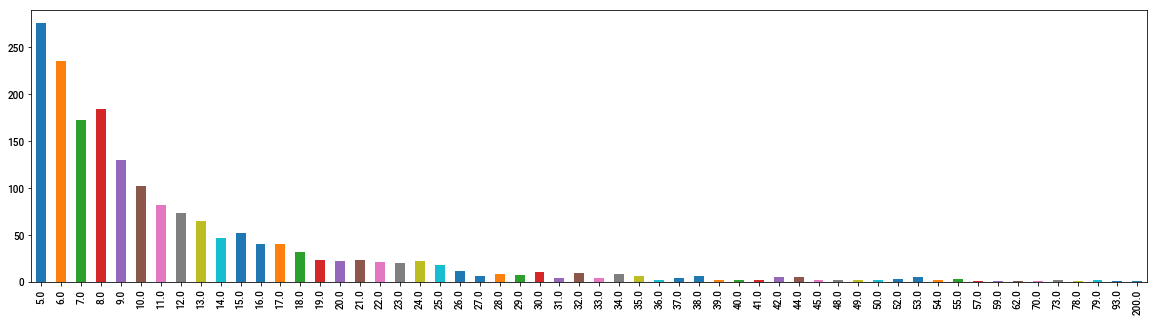

In [29]:
authors['art_count'].value_counts().sort_index().plot.bar(figsize=(20,5))

## Acquisition paths distance and clustering

In [30]:
ARTISTS_SEQUENCES = dict()
nmod = 5
for i, row in authors.iterrows():
    ARTISTS_SEQUENCES[row['Id artist']] = row['sequence']
ARTISTS = list(ARTISTS_SEQUENCES.keys())
convert = {'C': 0, 'P': 1, 'F': 2, 'M': 3, 'A': 4}
ranking = {'C': 1, 'P': 1, 'F': 0.5, 'M': 0.1, 'A': 0.1}

#### Compute Markov Matrix

In [31]:
def compute_markov(art_sequences):
    markov = np.zeros((nmod, nmod))
    count = np.zeros(nmod)
    for artist in list(art_sequences.keys()):
        path = art_sequences[artist]
        for i in range(1, len(path)):
            markov[convert[path[i-1]], convert[path[i]]] += 1
            count[convert[path[i-1]]] += 1
    for i in range(nmod):
        if count[i] == 0:
            markov[i,i] = 1
            count[i] = 1
    markov = markov / count[:,None]
    return markov

In [32]:
markov = compute_markov(ARTISTS_SEQUENCES)
penalty = markov.mean()
print(markov)

[[0.4        0.11221498 0.04381107 0.19983713 0.24413681]
 [0.16813244 0.41670978 0.04681842 0.33600621 0.03233316]
 [0.20641283 0.16933868 0.33266533 0.26653307 0.0250501 ]
 [0.16829464 0.21168935 0.03554844 0.52858287 0.05588471]
 [0.3991664  0.04103879 0.00833601 0.15068932 0.40076948]]


#### Defining costs for edit distance

In [33]:
SUB_COST = 2
DEL_COST = 1
INS_COST = 1

In [34]:
def insertion_cost(i, j, str1, str2):
    if i == 1:
        return 1
    elif i-2 <= 0:
        return 1
    elif str2[j-1] == str1[i-2]:
        return 0.5
    else:
        return 1

In [35]:
def deletion_cost(i, j, str1, str2):
    if i == 1:
        return 1
    elif i-2 <= 0:
        return 1
    elif str2[j-1] == str1[i-2]:
        return 0.5
    else:
        return 1

In [36]:
def substitution_cost(i, j, str1, str2):
    if str1[i-1] == str2[j-1]:
        return 0
    elif i == 1:
        return 2
    elif str2[j-1] == str1[i-2]:
        return 0.5
    elif i >= len(str1):
        return 2
    elif str2[j-1] == str1[i]:
        return 0.5
    else:
        return 2

#### Lenvenshtein edit distance

In [37]:
def levenshtein(str1, str2):
    # en fait, Wagner–Fischer algorithm: http://www.inrg.csie.ntu.edu.tw/algorithm2014/homework/Wagner-74.pdf
    # str1 = linearize(str1)
    # str2 = linearize(str2)
    n = len(str1)
    m = len(str2)
    d = np.zeros((n+1, m+1))
    for i in range(n+1):
        d[i,0] = i
    for j in range(m+1):
        d[0,j] = j
    for i in range(1,n+1):
        for j in range(1,m+1):
            d[i,j] = min(
                d[i  ,j-1] + insertion_cost(i, j, str1, str2),    # Deletion cost
                d[i-1,j  ] + deletion_cost(i, j, str1, str2),     # Insertion cost
                d[i-1,j-1] + substitution_cost(i, j, str1, str2)) # Substition cost
    ldist = d[n,m] / max(n, m)
    return ldist

#### Needleman–Wunsch optimal matching

In [38]:
def needlemanwunsch(str1, str2):
    # https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm
    n = len(str1)
    m = len(str2)
    d = np.zeros((n+1, m+1))
    for i in range(n+1):
        d[i,0] = -i
    for j in range(m+1):
        d[0,j] = -j
    for i in range(1,n+1):
        for j in range(1,m+1):
            d[i,j] = max(
                d[i  ,j-1] + penalty,     # Deletion cost
                d[i-1,j  ] + penalty,     # Insertion cost
                d[i-1,j-1] + markov[convert[str1[i-1]], convert[str2[j-1]]]) # Substition cost
    ldist = d[n,m] / max(n, m)
    return ldist

#### Markov distribution distance

In [39]:
def markovdistance(mark1, mark2):
    n = len(mark1)
    ldist = np.zeros(n)
    for i in range(n):
        ldist[i] = np.linalg.norm(mark1[i]-mark2[i])
    return np.linalg.norm(ldist)

#### Sequence distance with various metrics

In [40]:
distance = np.zeros((len(ARTISTS_SEQUENCES), len(ARTISTS_SEQUENCES)))

for i, artist_source in enumerate(ARTISTS):
    if i % 500 == 0:
        print(round(100*i/len(ARTISTS_SEQUENCES)), '%')
    sequence_source = ARTISTS_SEQUENCES[artist_source]
    for j, artist_target in enumerate(ARTISTS):
        sequence_target = ARTISTS_SEQUENCES[artist_target]
        distance[i, j] = levenshtein(sequence_source, sequence_target)

0 %
28 %
55 %
83 %


#### Distance between Markov matrix of each sequence

In [41]:
distance_m = np.zeros((len(ARTISTS_SEQUENCES), len(ARTISTS_SEQUENCES)))

for i, artist_source in enumerate(ARTISTS):
    if i % 500 == 0:
        print(round(100*i/len(ARTISTS_SEQUENCES)), '%')
    src = {artist_source: ARTISTS_SEQUENCES[artist_source]}
    mrk_src = compute_markov(src)
    for j, artist_target in enumerate(ARTISTS):
        dst = {artist_target: ARTISTS_SEQUENCES[artist_target]}
        mrk_dst = compute_markov(dst)
        distance_m[i, j] = markovdistance(mrk_src, mrk_dst)

0 %
28 %
55 %
83 %


#### Clustering

In [42]:
NUM_CLUSTERS = 7
kmeans = cluster.KMeans(NUM_CLUSTERS, random_state=1234).fit(distance_m)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

#### Plot

In [43]:
def plot_clusters(dataset, labels, centroids):
    fig, ax = plt.subplots(figsize=(7,7))

    pca = PCA(n_components=2, random_state=123)
    reduced_data = pca.fit_transform(dataset)
    reduced_centroids = pca.transform(centroids)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
    
    for i, c in enumerate(reduced_centroids):
        ax.annotate(str(i), c, size=16, ha='center', path_effects=[pe.withStroke(linewidth=4, foreground="w")])
    plt.xticks(())
    plt.yticks(())
    plt.show()

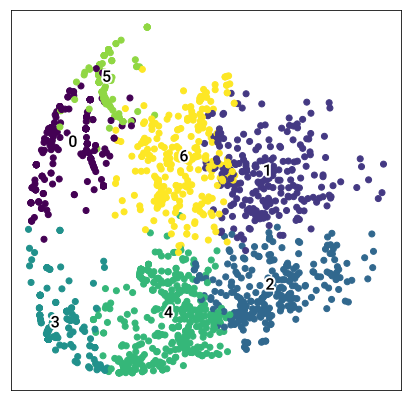

In [44]:
plot_clusters(distance_m, labels, centroids)

#### Inspect clusters

In [45]:
i = 1
print('Cluster n°%i containing:' % (i))
for j, artist in enumerate(ARTISTS):
    if labels[j] == i:
        sequence = ARTISTS_SEQUENCES[artist]
        # print('  - %s' % (sequence))

Cluster n°1 containing:


## Gender-oriented study of markov matrix

In [46]:
F_SEQUENCES, H_SEQUENCES = dict(), dict()
first_f, first_h = [], []
for i, row in authors.iterrows():
    if row['Gender'] == 'féminin':
        F_SEQUENCES[row['Id artist']] = row['sequence']
        first_f.append(row['sequence'][0])
    elif row['Gender'] == 'masculin':
        H_SEQUENCES[row['Id artist']] = row['sequence']
        first_h.append(row['sequence'][0])
F_ARTISTS = list(F_SEQUENCES.keys())
H_ARTISTS = list(H_SEQUENCES.keys())
first_f = pd.Series(first_f).value_counts(True).tolist()
first_h = pd.Series(first_h).value_counts(True).tolist()
print(len(F_ARTISTS), len(H_ARTISTS))

238 1573


In [47]:
markov_h = compute_markov(H_SEQUENCES)
markov_f = compute_markov(F_SEQUENCES)
print(markov_h, '\n\n', markov_f)

[[0.40444444 0.11648148 0.04203704 0.20222222 0.23481481]
 [0.1658606  0.41678521 0.04722617 0.33798009 0.03214794]
 [0.20180383 0.16572717 0.33370913 0.27508455 0.02367531]
 [0.16569921 0.21090589 0.0353562  0.53474055 0.05329815]
 [0.40685714 0.04190476 0.0087619  0.15657143 0.38590476]] 

 [[0.36756757 0.08108108 0.05675676 0.18243243 0.31216216]
 [0.19088319 0.41595442 0.04273504 0.31623932 0.03418803]
 [0.24324324 0.1981982  0.32432432 0.1981982  0.03603604]
 [0.19464286 0.21964286 0.0375     0.46607143 0.08214286]
 [0.3582996  0.03643725 0.00607287 0.1194332  0.47975709]]


## Markov simulation

In [48]:
def simulate_path(first, matrix, length=15):
    choices = ['C', 'P', 'F', 'M', 'A']
    path = np.random.choice(choices, p=first)
    for i in range(length):
        p = matrix[convert[path[-1]]]
        path += np.random.choice(choices, p=p)
    return path

In [49]:
simulate_path(first_f, markov_f, length=15)

'PCACFPPCAAAAACCM'

## Retour au sérieux : des stats qui MARCHENT

In [50]:
authors_f = authors[authors['Gender'] == "féminin"]
authors_h = authors[authors['Gender'] == "masculin"]

In [51]:
pd.concat([authors_h['sequence'].apply(set).apply(len).value_counts(True),
           authors_f['sequence'].apply(set).apply(len).value_counts(True)], 1, sort=False)

,sequence,sequence
1,0.077559,0.037815
2,0.329943,0.365546
3,0.335664,0.361345
4,0.208519,0.222689
5,0.048315,0.012605


In [52]:
pd.concat([authors_h['sequence'].str[0].value_counts(),
           authors_f['sequence'].str[0].value_counts()], 1, sort=False)

,sequence,sequence
C,755,138
P,301,27
M,280,38
A,196,29
F,41,6


In [53]:
pd.concat([authors_h['sequence'].str[1].value_counts(),
           authors_f['sequence'].str[1].value_counts()], 1, sort=False)

,sequence,sequence
C,610,89
M,333,39
P,319,33
A,257,64
F,54,13


In [54]:
pd.concat([authors_h['sequence'].str[2].value_counts(),
           authors_f['sequence'].str[2].value_counts()], 1, sort=False)

,sequence,sequence
C,569,99
M,379,52
P,282,28
A,274,52
F,69,7


In [55]:
pd.concat([authors_h['sequence'].str[-1].value_counts(),
           authors_f['sequence'].str[-1].value_counts()], 1, sort=False)

,sequence,sequence
M,570,66
P,336,45
C,311,50
A,289,65
F,67,12


In [56]:
pd.concat([authors_h['sequence'].str[-2].value_counts(),
           authors_f['sequence'].str[-2].value_counts()], 1, sort=False)

,sequence,sequence
M,515,60
C,399,60
A,317,60
P,277,46
F,65,12


## Classification en troncatures des chaines

Simplify sequences using only National (N) and Local (L)

In [57]:
def simplify(string):
    res = string[:]
    for l, r in {'A': 'L', 'C': 'N', 'P': 'N', 'F': 'L', 'M': 'L'}.items():
        res = res.replace(l, r)
    return res

Keep only artists with non linear (only local or only national) careers

In [58]:
linear_authors = authors[authors['sequence'].apply(simplify).apply(set).apply(len) == 1].copy()
multi_authors = authors[authors['sequence'].apply(simplify).apply(set).apply(len) > 1].copy()
len(linear_authors), len(multi_authors)

(196, 1615)

Evaluates whether a string contains in majority national or local onstitutions, or both equaly

In [59]:
def evaluate(string):
    nat_score = string.count('C') + string.count('P')
    loc_score = string.count('F') + string.count('M') + string.count('A')
    if 2 * nat_score >= 3 * loc_score:
        return 'N'
    elif 2 * loc_score >= 3 * nat_score:
        return 'L'
    else:
        return 'O'

Computes entropy in a string (i.e. a set) using two categories: national (N) or local (L)

In [60]:
def entropy(string):
    string = simplify(string)
    p = string.count('N') / len(string)
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1-p) * np.log2(1-p)

Computes the best split of a string in 2 substrings using argmax information gain

In [61]:
def binary_classif(string, display=False):
    n = len(string)
    e1 = entropy(string)
    infogain = [0]
    for i in range(1, n):
        e2 = entropy(string[0:i])
        e3 = entropy(string[i:n])
        infogain.append(e1 - e2*i/n - e3*(n-i)/n)
    if display: print(max(infogain))
    return np.argmax(infogain)

Computes the best split of a string in 3 substrings using argmax information gain

In [62]:
def tertiary_classif(string, display=False):
    n = len(string)
    e1 = entropy(string)
    infogain = [0]
    index = [(0,0)]
    for i in range(1, n):
        for j in range(i+1, n):
            e2 = entropy(string[0:i])
            e3 = entropy(string[i:j])
            e4 = entropy(string[j:n])
            infogain.append(e1 - e2*i/n - e3*(j-i)/n - e4*(n-j)/n)
            index.append((i, j))
    if display: print(max(infogain))
    return index[np.argmax(infogain)]

Try to avoid too many cuts if not necessary

In [63]:
def best_split(string):
    i, j = tertiary_classif(string)
    if i == 1 or j == len(string)-1 or j-i == 1:
        k = binary_classif(string)
        return (k,)
    else:
        return (i, j)

Tests

In [64]:
string = 'PMCP'
k = binary_classif(string, True)
i, j = tertiary_classif(string, True)
print("Binary cut:", string[0:k], string[k:])
print("Tertiary cut:", string[0:i], string[i:j], string[j:])

0.31127812445913283
0.8112781244591328
Binary cut: PM CP
Tertiary cut: P M CP


In [65]:
multi_authors['split'] = multi_authors['sequence'].apply(best_split)

In [66]:
for i, row in multi_authors.iterrows():
    string = row['sequence']
    if len(row['split']) == 2:
        h, j = row['split']
        multi_authors.loc[i, 'simple_seq'] = evaluate(string[0:h]) + evaluate(string[h:j]) + evaluate(string[j:])
    elif len(row['split']) == 1:
        k = row['split'][0]
        multi_authors.loc[i, 'simple_seq'] = evaluate(string[0:k]) + evaluate(string[k:])
    else:
        print('error')

In [67]:
multi_authors[['sequence', 'split', 'simple_seq']].sample(10)

,sequence,split,simple_seq
27416,CCMCCF,"(5,)",NL
26226,MMCMMMMMM,"(3,)",LL
32167,MPPFMPPPPC,"(3, 5)",NLN
21964,PCCACACAAAAAACA,"(7, 13)",NLO
28413,CAACACA,"(1,)",NL
3456,MMMMMMCFMFFCMMMM,"(6,)",LL
22225,ACCCACC,"(1,)",LN
15415,CCCCAACACACACAA,"(4, 6)",NLO
35312,CAMAC,"(1,)",NL
28627,CMPPPP,"(2,)",ON


In [68]:
multi_authors['simple_seq'].value_counts()

NL     433
LN     172
NLN    167
LNL    100
NN      90
NO      86
OL      76
NLL     57
NOL     56
ONL     55
NNL     52
LL      51
NLO     49
LO      33
ON      29
OLN     23
LLN     14
LNO     10
OLO     10
LNN     10
NON      9
LON      7
ONO      7
OLL      7
LOL      5
NNN      3
NNO      3
LLO      1
Name: simple_seq, dtype: int64

In [69]:
multi_authors[multi_authors['simple_seq'] == 'NL'][['sequence', 'split']]

,sequence,split
314,PPMMFMC,"(2,)"
526,CAACCA,"(1,)"
750,PMFMMMM,"(1,)"
852,CCCACPCF,"(7,)"
992,CCCAA,"(3,)"
1001,PMMMPPMMPMMMPMP,"(1,)"
1032,CCCCM,"(4,)"
1131,PFMMPFMFP,"(1,)"
1137,CAAAAAA,"(1,)"
1198,CCPCAMM,"(4,)"
